In [245]:
# import tool and package

# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [246]:
# 获取数据

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [247]:
# 查看数据中的特征项的名称
# PassengerID（ID）
# Survived(存活与否)
# Pclass（客舱等级，较为重要）
# Name（姓名，可提取出更多信息）
# Sex（性别，较为重要）
# Age（年龄，较为重要）
# Parch（直系亲友）
# SibSp（旁系）
# Ticket（票编号）
# Fare（票价）
# Cabin（客舱编号）
# Embarked（上船的港口编号）

print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [285]:
# 数据一览 & 查看哪些数据项是缺失的

train_df.head()
# train_df.info()
# train_df.describe()
# (train_df.isnull()).sum()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1


In [249]:
# 初步了解数据之间的相关性,为构造特征工程以及模型建立做准备

train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

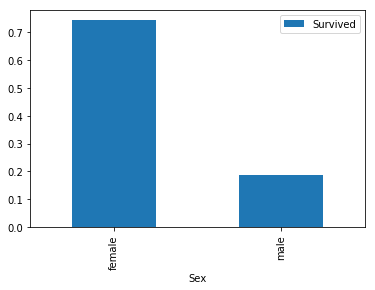

In [250]:
# 对特征进行分组/聚合运算：性别

train_df[['Sex', 'Survived']].groupby('Sex').agg('mean').plot(kind='bar')

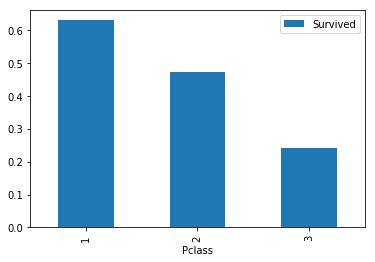

In [251]:
# 对特征进行分组/聚合运算：客舱等级

train_df[['Pclass', 'Survived']].groupby('Pclass').agg('mean').plot(kind='bar')

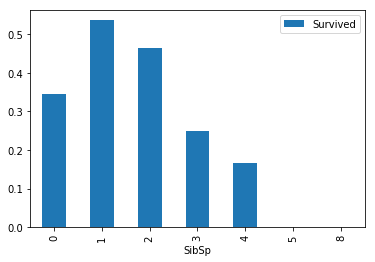

In [252]:
train_df[['SibSp', 'Survived']].groupby('SibSp').agg('mean').plot(kind='bar')

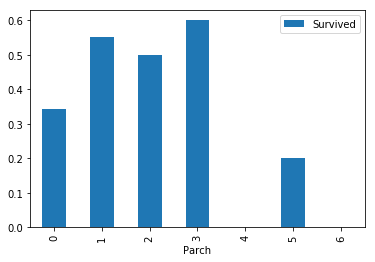

In [253]:
train_df[['Parch', 'Survived']].groupby('Parch').agg('mean').plot(kind='bar')

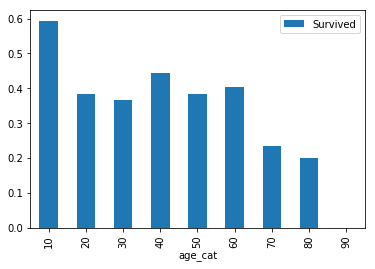

In [254]:
# 年龄由于是连续的，因此需要离散化

# 分箱：人为设定范围
train_df_temp = train_df[['Age', 'Survived']].sort_values(by='Age')
bins = [0,10,20,30,40,50,60,70,80,90]
categories = pd.cut(train_df_temp['Age'], bins)
train_df_temp['age_cat'] = pd.cut(train_df_temp["Age"],bins, labels=['10','20','30','40','50','60','70','80','90'])
train_df_temp

train_df_temp[['age_cat', 'Survived']].groupby('age_cat').agg('mean').plot(kind='bar')

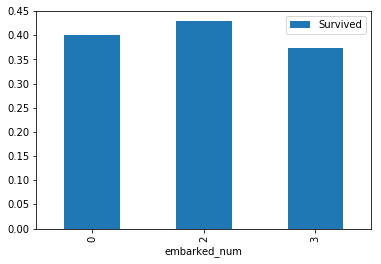

In [284]:
# 登舱口由于是字符串，因此需要进行编码

# 检测缺失值
(train_df['Embarked'].isnull()).sum()
# 填充缺失值
train_df_embark_temp = train_df['Embarked'].fillna('NAN')

le = sklearn.preprocessing.LabelEncoder() 
le.fit(["S", "C", "Q", 'NAN'])
train_df_temp['embarked_num'] = le.transform(train_df_embark_temp)
# train_df_temp['embarked_num']

train_df_temp[['embarked_num', 'Survived']].groupby('embarked_num').agg('mean').plot(kind='bar')

In [256]:
# Title Feature(New)：不同称呼的乘客幸存率不同
# 新增Title特征，从姓名中提取乘客的称呼，归纳为六类。


Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

train_df['Title'] = train_df['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
train_df['Title'] = train_df['Title'].map(Title_Dict)

test_df['Title'] = test_df['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Title'].map(Title_Dict)

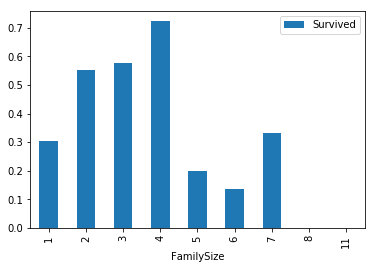

In [257]:
# FamilyLabel Feature(New)：家庭人数为2到4的乘客幸存率较高
# 新增FamilyLabel特征，先计算FamilySize=Parch+SibSp+1，然后把FamilySize分为三类。

train_df['FamilySize']=train_df['SibSp']+train_df['Parch']+1
test_df['FamilySize']=test_df['SibSp']+test_df['Parch']+1
train_df[['FamilySize', 'Survived']].groupby('FamilySize').agg('mean').plot(kind='bar')

In [258]:
# 按生存率把FamilySize分为三类，构成FamilyLabel特征。
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
train_df['FamilyLabel']=train_df['FamilySize'].apply(Fam_label)
test_df['FamilyLabel']=test_df['FamilySize'].apply(Fam_label)

In [259]:
# 数据清洗：缺失值填充

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
FamilyLabel    891 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


In [288]:
# Age Feature：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。
from sklearn.ensemble import RandomForestRegressor

age_df = train_df[['Age','Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values

y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
train_df.loc[(train_df.Age.isnull()), 'Age' ] = predictedAges 

age_df = test_df[['Age','Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
age_df
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
test_df.loc[(test_df.Age.isnull()), 'Age' ] = predictedAges 

array([], shape=(0, 10), dtype=float64)

In [289]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
FamilySize     891 non-null int64
FamilyLabel    891 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int6

In [263]:
# Embarked Feature：Embarked缺失量为2，

train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,1


In [264]:
train_df.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           78.2667
        Q           90.0000
        S           52.0000
2       C           24.0000
        Q           12.3500
        S           13.5000
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [265]:
# 缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。
train_df['Embarked'] = train_df['Embarked'].fillna('C')

In [201]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [276]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Title          418 non-null object
FamilySize     418 non-null int64
FamilyLabel    418 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 45.8+ KB


In [277]:
# Fare缺失量为1，缺失Fare信息的乘客的Embarked为S，Pclass为3，所以用Embarked为S，Pclass为3的乘客的Fare中位数填充。

fare=test_df[(test_df['Embarked'] == "S") & (test_df['Pclass'] == 3)].Fare.median()
test_df['Fare']=test_df['Fare'].fillna(fare)

In [202]:
# 同组识别 把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。

train_df['Surname']=train_df['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(train_df['Surname'].value_counts())
train_df['FamilyGroup'] = train_df['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=train_df.loc[(train_df['FamilyGroup']>=2) & ((train_df['Age']<=12) | (train_df['Sex']=='female'))]
Male_Adult_Group=train_df.loc[(train_df['FamilyGroup']>=2) & (train_df['Age']>12) & (train_df['Sex']=='male')]

In [203]:
# 发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难。
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,79
0.000000,26
0.750000,2
0.333333,1
0.142857,1


In [204]:
# 绝大部分成年男性组的平均存活率也为1或0。
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,83
1.000000,13
0.500000,6
0.333333,2
0.250000,1


In [278]:
all_data=pd.concat([train_df, test_df], sort=False)
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.values[:,1:]
y = train.values[:,0]

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import SelectKBest

# pipe=Pipeline([('select',SelectKBest(k='all')), 
#                ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

# param_test = {'classify__n_estimators':list(range(20,50,2)), 
#               'classify__max_depth':list(range(3,60,3))}
# gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
# gsearch.fit(X,y)
# print(gsearch.best_params_, gsearch.best_score_)

In [269]:
from sklearn.pipeline import make_pipeline
# select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
clf.fit(X, y)
# pipeline = make_pipeline(select, clf)
# pipeline.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=True)

In [279]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
cv_scores = cross_val_score(clf, X, y,
                                scoring="neg_mean_squared_error", cv=10)
cv_rmse_scores = np.sqrt(-cv_scores)
display_scores(cv_rmse_scores)
# cv_score = cross_validation.cross_val_score(clf, X, y, cv= 10)
# print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

Scores: [0.43461349 0.40824829 0.48575205 0.33520076 0.33520076 0.42399915
 0.44971901 0.48575205 0.41053541 0.39886202]
Mean: 0.4167883008259176
Standard deviation: 0.04971176805230661


In [281]:
predictions = clf.predict(test)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": predictions.astype(np.int32)})
submission.to_csv("./submission.csv", index=False)